# **EMCNet: Automated COVID-19 diagnosis from X-ray images using convolutional neural network and ensemble of machine learning classifiers**

References


1.   [Automated COVID-19 diagnosis from X-ray images using convolutional neural network and ensemble of machine learning classifiers](https://www.sciencedirect.com/science/article/pii/S2352914820306560)
2.   [ImageNet training in PyTorch](https://github.com/pytorch/examples/blob/537f6971872b839b36983ff40dafe688276fe6c3/imagenet/main.py)
3. [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/)
4. [Kaggle COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
5. [NIH Chest X-ray Dataset](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345)
6. [XRay CNN in PyTorch](https://www.kaggle.com/salvation23/xray-cnn-pytorch)
7. [Plot ROC curve](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
8. [Plot Confusion Matrix](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)
9. [CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)



**Install missing packages**

Some required packages are not installed by default in Google Colab. It is necessary to manually install them for each user session.


In [2]:
!pip install utils
!pip install split-folders tqdm
!pip install treepy

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for treepy: filename=treepy-0.5-cp37-none-any.whl size=6308 sha256=63d142a6285f315724b334349a0fda3dbf5a99013e17344abc4a6deb148aacf4
  Stored in directory: /root/.cache/pip/wheels/d4/84/47/9f8899ee74c439c2dc931163adc5cb692b6ed25e6b5eceeb87
  Created wheel for colored: filename=colored-1.4.2-cp37-none-any.whl size=14003 sha256=600040d38ee28119baac377d31ba9cdfa8b2c3d82302a921f8ff813dbe7aa836
  Stored in directory: /root/.cache/pip/wheels/ec/10/5e/d17d5ef644e1051a753bd98f3796789ec39bc3337cd36637f3
Successfully built treepy colored


**Setup the environment and variables**

The following steps are done

1.   Import all the necessary modules
2.   Set the random number seed. This is required for reproducing the results every time.
3. Set the global variables 

If the flag *save_cloud* is *True*, the outputs will be stored in Google Drive. When this option is selected, the notebook will prompt to enter an API key from Google.



In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils as utils
import time
import math
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import gdown
import splitfolders
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import glob
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import pickle
from google.colab import drive
from torchsummary import summary
import treepy as treepy

# Set the random number seed. This allows results to be reproduced
seed = 1619
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# If True, the output will be stored in Google Drive and will be permanent. Otherwise it will be stored in the Colab workspace which is highly volatile
save_cloud = True

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100

# Global variables
DATASET_URL = 'https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw'
DATA_PATH = "/content/data_split/"
UNZIP_LOC = '/content/data/'
ZIPFILE = 'dataset.zip'

if save_cloud:
  # Mount Google Drive. This will require manually authenticating with an API key per user session
  drive.mount('/content/gdrive', force_remount=True)
  MODEL_ROOT = '/content/gdrive/My Drive/models/'
else:
  MODEL_ROOT = '/content/models/'

MODEL_NAME= 'EMCNet'
MODEL_PATH = f"{MODEL_ROOT}/{MODEL_NAME}/{datetime.today().strftime('%m-%d-%Y')}/{datetime.today().strftime('%H:%M')}/"

INDEX_LABEL = {}

# Flag to check if GPU is available for use.
use_gpu = torch.cuda.is_available()

# Location for storing best model and checkpoints
if not os.path.exists(MODEL_PATH):
   os.makedirs(MODEL_PATH, exist_ok=True)


Mounted at /content/gdrive


**Environment details**

Google Colab provides GPUs that help with resource intensive Deep Learning operations. It also comes pre-loaded with PyTorch that is required in this notebook.

In [4]:
# GPU Information
!nvidia-smi

# PyTorch library version
print(f"\n\nPyTorch version: {torch.__version__}")


Sat May  8 06:42:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Download dataset**

The dataset is stored in Google Drive as a zip file. The following code downloads the zip file to the Colab workspace and then unzips it.

The dataset contains 7200 Chest X Rays in total. This is a balanced dataset with 3600 COVID XRays and 3600 non-COVID XRays.

In [5]:
# Remove existing dataset files to avoid conflicts
!rm -rf "{UNZIP_LOC}"
!rm -rf "{DATA_PATH}"
!rm "{ZIPFILE}"

# Download from Google drive to Colab
gdown.download(DATASET_URL, ZIPFILE, quiet=False)

# Unzip the file in the Colab workspace
!unzip -q "{ZIPFILE}" -d "{UNZIP_LOC}"

rm: cannot remove 'dataset.zip': No such file or directory


Downloading...
From: https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw
To: /content/dataset.zip
1.55GB [00:08, 178MB/s]


Validate the dataset image count 

In [6]:
assert len(os.listdir(UNZIP_LOC + 'COVID')) == 3600, "COVID Xray count wrong. Imbalanced dataset"
assert len(os.listdir(UNZIP_LOC + 'Non-COVID')) == 3600, "Non-COVID Xray count wrong. Imbalanced dataset"

**Dataset split**

The dataset needs to be split for training, test and validation. This train/test/validation ratio is 60% : 20% : 20%.

In [7]:
splitfolders.ratio(UNZIP_LOC, output= DATA_PATH, seed=seed, ratio=(0.6,0.2,0.2))

Copying files: 7200 files [00:19, 363.44 files/s]


Validate the count of images in the dataset to ensure that the datasplit is correct.

In [8]:
def get_XRay_count(folder, data_path=DATA_PATH):

    covid_path = data_path + folder + '/COVID' 
    non_covid_path = data_path + folder + '/Non-COVID'

    covid_count = (len(os.listdir(covid_path)))
    non_covid_count = (len(os.listdir(non_covid_path)))

    return covid_count, non_covid_count

# Get total files in the input dataset and the split dataset
total_files = sum([len(files) for _, _, files in os.walk(UNZIP_LOC)])
total_split_files = sum([len(files) for _, _, files in os.walk(DATA_PATH)])

# Get count of images in the dataset split subfolders
train_covid, train_non_covid = get_XRay_count('train')
val_covid, val_non_covid = get_XRay_count('val')
test_covid, test_non_covid = get_XRay_count('test')
total_covid = train_covid + val_covid + test_covid
total_non_covid = train_non_covid + val_non_covid + test_non_covid

total_train = train_covid + train_non_covid
total_val = val_covid + val_non_covid
total_test = test_covid + test_non_covid

assert total_files == total_split_files, "XRay count after the dataset split is wrong."

# Validate the number of entries in train, test and val folders
assert (train_covid, train_non_covid) == (2160, 2160), "train folder XRay count is wrong"
assert (val_covid, val_non_covid) == (720, 720), "val folder XRay count is wrong"
assert (test_covid, test_non_covid) == (720, 720), "test folder XRay count is wrong"

View details about the dataset

In [9]:
print("Dataset directory structure\n")
!treepy -d $DATA_PATH

print("\n\nDataset Image Count\n")
print(f"-"*53)
print(f"{'Dataset':<15} {'COVID':<15} {'Non-COVID':<15} {'Total':<15}")
print(f"-"*53)
print(f"{'Training':<15} {train_covid:<15} {train_non_covid:<15} {total_train:<15}")
print(f"{'Validation':<15} {val_covid:<15} {val_non_covid:<15} {total_val:<15}")
print(f"{'Testing':<15} {test_covid:<15} {test_non_covid:<15} {total_test:<15}")
print(f"_"*53)
print(f"{'':<15} {total_covid:<15} {total_non_covid:<15} {total_split_files:<15}")

Dataset directory structure

data_split/
├── test/
│   ├── Non-COVID/
│   └── COVID/
├── train/
│   ├── Non-COVID/
│   └── COVID/
└── val/
    ├── Non-COVID/
    └── COVID/


Dataset Image Count

-----------------------------------------------------
Dataset         COVID           Non-COVID       Total          
-----------------------------------------------------
Training        2160            2160            4320           
Validation      720             720             1440           
Testing         720             720             1440           
_____________________________________________________
                3600            3600            7200           


**Image Pre-processing**

The following image transformations are done on the images.


1.   Resize to 224 x 224 pixels
2.   Normalize to ensure that every pixel has a similar data distribution.



In [10]:
def get_classlabels(img_data):

  # Has the format {'COVID': 0, 'Non-COVID': 1}
  class_idx = img_data.class_to_idx

  # Return in format {0: 'COVID', 1: 'Non-COVID'}
  return dict(zip(class_idx.values(), class_idx.keys()))

def load_data(data_path=DATA_PATH):

    # Pre-processing transforms to be applied on input images
    transformed_img = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    train_path = data_path + '/train' 
    train_data = datasets.ImageFolder(root=train_path, 
                                      transform=transformed_img)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle= True)

    # Get the dictionary that maps integer labels  to label name (COVID/Non-COVID) 
    class_label = get_classlabels(train_data)

    val_path = data_path + '/val' 
    val_data = datasets.ImageFolder(root=val_path, 
                                    transform=transformed_img)
    val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE,shuffle= False)
    
    test_path = data_path + '/test' 
    test_data = datasets.ImageFolder(root=test_path, 
                                    transform=transformed_img)
    test_loader = torch.utils.data.DataLoader(test_data, 
                                             batch_size=BATCH_SIZE,shuffle = False)    
    
    return train_loader, val_loader, test_loader, class_label

**Loading DataLoaders**

Transform the images and load the DataLoader objects for  train/test/val. This will be used for training and testing the model later.

In [11]:
# Call the function to load the train, test and validation dataloaders from the dataset.
train_loader, val_loader, test_loader, INDEX_LABEL = load_data()

# Validate the length of the dataloaders as per the datasplit ratio
assert len(train_loader) == math.ceil(total_train/BATCH_SIZE), "Train dataloader length is wrong"
assert len(val_loader) == math.ceil(total_val/BATCH_SIZE), "Val dataloader length is wrong"
assert len(test_loader) == math.ceil(total_test/BATCH_SIZE), "Test dataloader length is wrong"

Show some sample images from the dataloader.

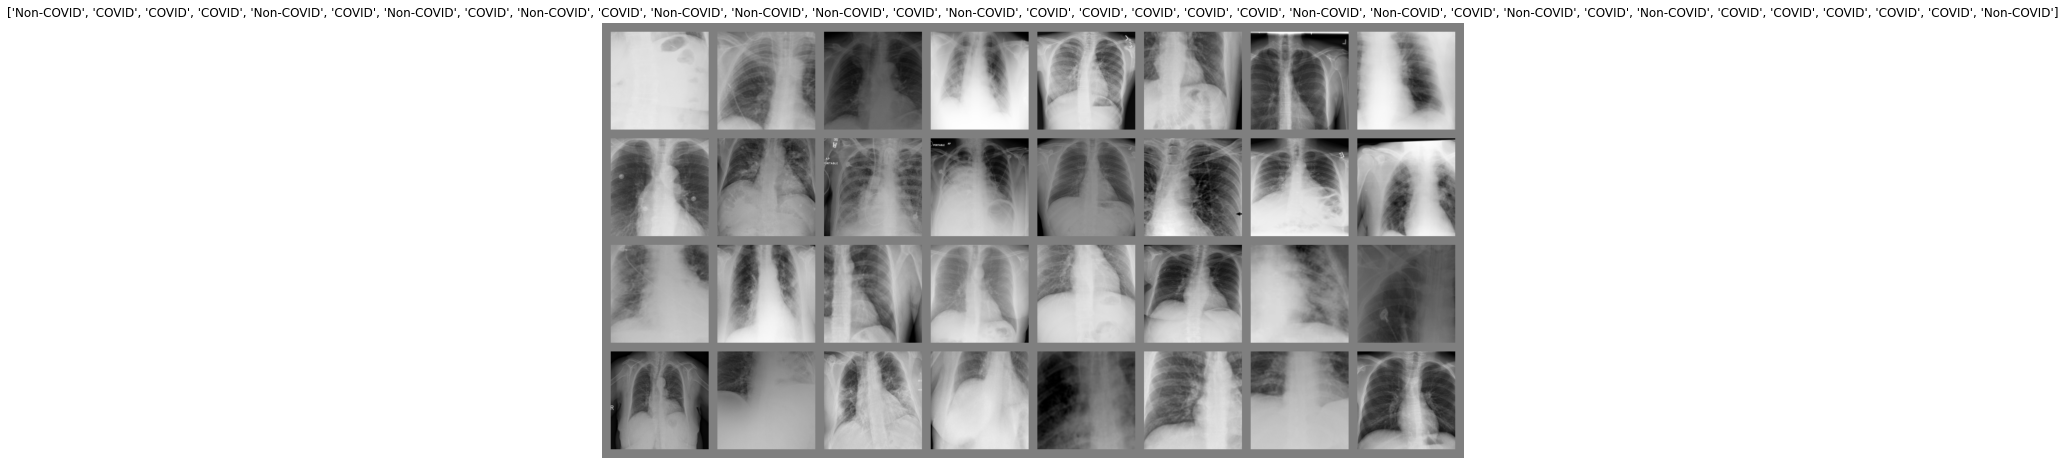

In [12]:
def img_show(img, img_labels):
  # Remove normalization
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20, 8))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(img_labels)
    plt.show()


# Load the next batch from the training data
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images, padding=20)

# Convert 0/1 to COVID/Non-COVID
img_labels = [INDEX_LABEL[int(x)] for x in labels]

# Plot images
img_show(img, img_labels)

# **Model Definition**

In the paper titled [A Deep Learning Approach to Detect COVID-19 Patients from Chest X-ray Images](https://www.researchgate.net/publication/344340531_A_Deep_Learning_Approach_to_Detect_COVID-19_Patients_from_Chest_X-ray_Images), Haque et al. proposed a model that uses Convolutional Neural Networks (CNNs) to predict COVID-19 patients using Chest X-Rays(CXRs).



In [13]:
class EMCNet(nn.Module):
    def __init__(self):
        super(EMCNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride=(1,1), padding=0)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = (3,3), stride=(1,1), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), stride=(1,1), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride=(1,1), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = (3,3), stride=(1,1), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), stride=(1,1), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Flatten()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features = 128 * 10 * 10, out_features = 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features = 64, out_features = 2),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.fc1(x)
        x = self.fc2(x)
        
        return x


**Loss function and Optimizer**

The Cross Entropy loss function is used along with the Adam optimzer.

In [14]:
model = EMCNet()

criterion = None
optimizer = None

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

if use_gpu:
    model.cuda()
    criterion = criterion.cuda()


**Model Summary**

Print the details of the model that defined.

In [15]:
summary(model,
        input_size = (3, 224, 224),
        batch_size = 32
        )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 222, 222]             896
            Conv2d-2        [32, 128, 220, 220]          36,992
              ReLU-3        [32, 128, 220, 220]               0
         MaxPool2d-4        [32, 128, 110, 110]               0
           Dropout-5        [32, 128, 110, 110]               0
            Conv2d-6         [32, 64, 108, 108]          73,792
              ReLU-7         [32, 64, 108, 108]               0
         MaxPool2d-8           [32, 64, 54, 54]               0
           Dropout-9           [32, 64, 54, 54]               0
           Conv2d-10          [32, 128, 52, 52]          73,856
             ReLU-11          [32, 128, 52, 52]               0
        MaxPool2d-12          [32, 128, 26, 26]               0
          Dropout-13          [32, 128, 26, 26]               0
           Conv2d-14          [32, 512,

**Helper functions**



1.   ***save_file*** - Save a Python object as a binary stream
2.   ***read_file*** - Read from a binary stream to a Python object
3.   ***save_checkpoint*** - Save the current epoch checkpoint for resuming training later
4.   ***get_savedmodel*** - This function is used to retrieve a previously saved model. It has 3 modes

*   BESTMODEL   -> Returns the best model after training(with the highest validation accuracy)
*   FINALMODEL  -> Returns the model from the last epoch after training
*   RESUMETRAIN -> Resumes training on an incomplete model and returns the model

5.   ***plot_training_metrics*** - Plot and save graphs with training metrics



In [25]:
def save_file(file_tosave, fname, fpath = MODEL_PATH):
  with open(f"{fpath}/{fname}.data", 'wb') as fh:
      pickle.dump(file_tosave, fh)

def read_file(fname, fpath = MODEL_PATH):
  with open(f"{fpath}/{fname}.data", 'rb') as fh:
      out = pickle.load(fh)
  return out

def save_checkpoint(model_state, checkpoint_path):
  torch.save(model_state, checkpoint_path)

def get_savedmodel(checkpoint_loc, mode = 'BESTMODEL'):

  # Create a new instance of the model and optimizer
  model = EMCNet()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  if use_gpu:
      model.cuda()

  # Load the model checkpoint
  checkpoint = torch.load(f"{checkpoint_loc}/last_model_state.pth")
  epoch_metrics = checkpoint['epoch_metrics']

  if mode == 'BESTMODEL':
    model.load_state_dict(torch.load(f"{checkpoint_loc}/best_model.pth"))
  else:
    # Load model and optimizer weights from the checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    epoch = checkpoint['epoch']
    
    if mode == 'RESUMETRAIN':
      # Train the model from the checkpoint and return the model
       model, epoch_metrics = train_model(model, train_loader, val_loader, start_epoch = epoch+1, epoch_metrics = epoch_metrics )

    # For mode = 'FINALMODEL', do nothing and just return whatever is already inside model and epoch_metrics

  # Return the required model
  return model, epoch_metrics

def plot_training_metrics(epoch_metrics):

  epoch_list=  list(range(1, NUM_EPOCHS+1))

  sns.set_style("darkgrid")
  plt.plot(epoch_list, epoch_metrics["val_losses"], label='Validation Loss')
  plt.plot(epoch_list, epoch_metrics["val_accuracy"], label='Validation Accuracy')
  plt.title('Accuracy/Training Loss over epochs')
  plt.ylabel('Accuracy/Loss')
  plt.xlabel('Epoch')
  plt.ylim([0, 1.05])
  plt.legend(['Validation Loss', 'Validation Accuracy'], loc='lower right')
  plt.savefig(f"{MODEL_PATH}Accuracy_Epoch.png")
  plt.show()

  plt.grid(True)
  plt.plot(epoch_list, epoch_metrics["epoch_timer"], label='Epoch Time')
  plt.title('Epoch Training Time')
  plt.ylabel('Training Time')
  plt.xlabel('Epoch')
  plt.legend(['Training Time'], loc='lower right')
  plt.savefig(f"{MODEL_PATH}Training_Epoch.png")
  plt.show()

**Training**

The model training consists of the following steps in each epoch:

1.   In the training mode, run the training steps for each batch within the training dataloader.
2.   In evaluation mode, validate the the model trained till then for each batch within the validation dataloader.
3.   Calculate validation accuracy. If validation accuracy is more than the best validation accuracy till then,

  *   Save the current model as the best model yet.
  *   Update best validation accuracy to current validation accuracy.

4.   Save model state as a checkpoint to resume training later in case of failure.    

At the end of training, the best model based on validaton accuracy is retrieved and returned.





In [17]:

def train_model(model, train_dataloader, val_dataloader, start_epoch = 0, epoch_metrics = {}, n_epoch=NUM_EPOCHS, optimizer=optimizer, criterion=criterion):

    # Set the model in training mode
    model.train()
    
    bestmodel_path = f"{MODEL_PATH}best_model.pth"

    # If this is a fresh run, initialize the metrics dict. If resuming training, epoch_metrics will already have data from the last checkpoint
    if len(epoch_metrics) == 0:
      epoch_metrics = dict({
          'train_losses' : [], 
          'train_accuracy': [], 
          'val_losses' : [], 
          'val_accuracy': [], 
          'epoch_timer': [], 
          'best_val_accuracy': 0.0,
          'best_epoch': 0
          })
   
    for epoch in range(start_epoch, n_epoch):
    
      epoch_starttime = time.time()
      running_train_loss = 0
      running_val_loss = 0
      running_train_correct = 0
      running_val_correct = 0

      # Training loop
      for images, labels in train_dataloader:

        if use_gpu:
            images, labels = images.cuda(), labels.cuda()

        # Clear parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
     
        #Calculate loss
        loss = criterion(outputs, labels )

        # Loss for batch
        running_train_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)

        # backward pass
        loss.backward()
        
        #Perform single optimization step
        optimizer.step()

        # Correct predictions
        running_train_correct += (preds == labels).sum().item()        

      # Validation loop
      for images, labels in val_dataloader:
        if use_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # Eval mode
        model.eval()
        
        output = model(images)
        loss = criterion(output, labels)
        _, preds = torch.max(output, 1)

        # Calculate validation loss and correct predictions
        running_val_loss += loss.item() * images.size(0)
        running_val_correct += (preds == labels).sum().item()
      
      # Put back in train mode for next epoch
      model.train()
  
      # Calculate loss and accuracy for training and validation
      epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
      epoch_train_accuracy = running_train_correct / len(train_dataloader.dataset)
      epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
      epoch_val_accuracy = running_val_correct / len(val_dataloader.dataset)

      print(
          f"Epoch {epoch+1}, Train loss : {epoch_train_loss:.4f}, Training accuracy: {epoch_train_accuracy:.4f}, "
          f"Validation loss :{epoch_val_loss:.4f}, Validation accuracy: {epoch_val_accuracy:.4f}"
          )
      
      # Arrays having values from all epochs for plotting graphs
      epoch_metrics["train_losses"].append(epoch_train_loss)
      epoch_metrics["train_accuracy"].append(epoch_train_accuracy)
      epoch_metrics["val_losses"].append(epoch_val_loss)
      epoch_metrics["val_accuracy"].append(epoch_val_accuracy)
      epoch_metrics["epoch_timer"].append(time.time() - epoch_starttime) 
      
      # If validation accuracy improves, save it so that the best model can be picked up at the end
      if epoch_val_accuracy > epoch_metrics["best_val_accuracy"]:
          print(f"Validation accuracy increased from {epoch_metrics['best_val_accuracy']:.4f} -> {epoch_val_accuracy:.4f}. Saving model...")
          epoch_metrics["best_val_accuracy"] = epoch_val_accuracy
          epoch_metrics["best_epoch"] = epoch + 1
          torch.save(copy.deepcopy(model.state_dict()), bestmodel_path)

      # Save the checkpoint after every epoch so that if needed, training can be resumed from this point later on
      checkpoint_path = f"{MODEL_PATH}last_model_state.pth"
      save_checkpoint({
          'epoch': epoch,
          'state_dict': copy.deepcopy(model.state_dict()),
          'optimizer' : copy.deepcopy(optimizer.state_dict()),
          'loss': criterion,
          'epoch_metrics': epoch_metrics
      }, checkpoint_path)
      
    # At the end of training, Retrieve best model
    print(f"\n\nTRAINING COMPLETE!! \n\nModel saved at {bestmodel_path}")
    model = EMCNet()
    if use_gpu:
      model.cuda()

    model.load_state_dict(torch.load(bestmodel_path))
    
    return model, epoch_metrics


**Training the model**

In [ ]:
# Train the model
model, epoch_metrics = train_model(model, train_loader, val_loader)

Epoch 1, Train loss : 0.6885, Training accuracy: 0.5377, Validation loss :0.6888, Validation accuracy: 0.5396
Validation accuracy increased from 0.0000 -> 0.5396. Saving model...
Epoch 2, Train loss : 0.6816, Training accuracy: 0.5711, Validation loss :0.6784, Validation accuracy: 0.5660
Validation accuracy increased from 0.5396 -> 0.5660. Saving model...
Epoch 3, Train loss : 0.6734, Training accuracy: 0.5896, Validation loss :0.6753, Validation accuracy: 0.5889
Validation accuracy increased from 0.5660 -> 0.5889. Saving model...
Epoch 4, Train loss : 0.6744, Training accuracy: 0.5889, Validation loss :0.6711, Validation accuracy: 0.5938
Validation accuracy increased from 0.5889 -> 0.5938. Saving model...
Epoch 5, Train loss : 0.6680, Training accuracy: 0.5889, Validation loss :0.6618, Validation accuracy: 0.6326
Validation accuracy increased from 0.5938 -> 0.6326. Saving model...
Epoch 6, Train loss : 0.6605, Training accuracy: 0.5938, Validation loss :0.6556, Validation accuracy: 0.

**Load previously trained model (only if required)**

Run this cell to load a previously trained model. If the saved model was not trained completely, set the *resume_training* flag to True to load the model from the checkpoint and resume training. This need not be run under usual circumstances.

In [18]:
# BESTMODEL   -> To return the best performing model
# FINALMODEL   -> To return the best model after the last epoch
# RESUMETRAIN -> To resume an incomplete training
mode = ''

if mode != '':
  # Update the model path to the output folder where the model is saved
  MODEL_PATH = '/content/gdrive/MyDrive/models/EMCNet/05-07-2021/06:34/'

  model, epoch_metrics = get_savedmodel(MODEL_PATH, mode)
  print(f"\nModel loaded from path -> {MODEL_PATH}")


Model loaded from path -> /content/gdrive/MyDrive/models/EMCNet/05-07-2021/06:34/


**Plot training metric graphs**

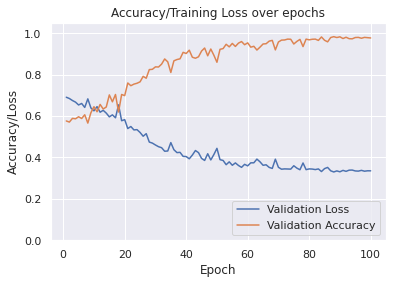

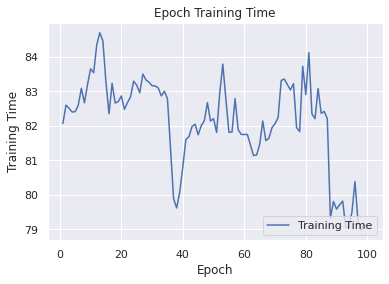

In [26]:
# epoch_metrics contains lists having accuracy and loss for each epoch during training and validation   
plot_training_metrics(epoch_metrics)

**Testing the model**

On the trained model, run the testing dataset and return the predictions along with the ground truths.

In [20]:
def eval_model(model, dataloader):

  model.eval()

  Y_pred = []
  Y_test = []

  with torch.no_grad():
      for images, labels in dataloader:
          if use_gpu:
            images, labels = images.cuda(), labels.cuda()
          y_pred = model(images)
          _, y_pred_tag = torch.max(y_pred, 1)

          Y_pred = np.append(Y_pred,y_pred_tag.cpu().detach().numpy())
          Y_test = np.append(Y_test,labels.cpu().numpy())

  print("MODEL TESTING COMPLETE!")
  return Y_pred, Y_test



# Test the model
y_pred, y_true = eval_model(model, test_loader)

MODEL TESTING COMPLETE!


**Calculating performance metrics**



TESTING METRICS
_______________

Accuracy: 0.9785 
Precision: 0.9786 
Recall: 0.9785 
F1: 0.9785 
Training Time: 8208.53 sec 




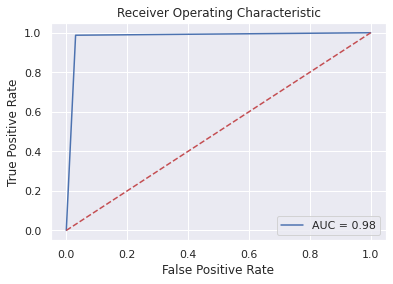

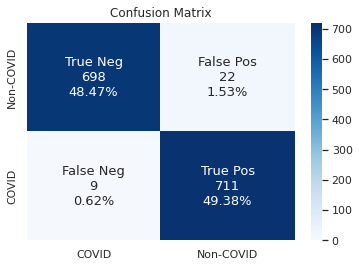

In [24]:
  # Print metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred
                                                                       , average='macro'
                                                                      )
 
  # ROC curve
  false_posrate, true_posrate, threshold = roc_curve(y_true, y_pred)
  
  # AUC
  roc_auc = auc(false_posrate, true_posrate)

  # Confusion matrix
  np.set_printoptions(threshold=np.inf) 
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Calculate the training time
  train_time = sum(epoch_metrics['epoch_timer'])

  print(f"TESTING METRICS\n{'_'*15}\n\nAccuracy: {accuracy:.4f} \nPrecision: {precision:.4f} \nRecall: {recall:.4f} \nF1: {fscore:.4f} \nTraining Time: {train_time:.2f} sec \n\n")  

  # Create a dictionary to save all the metrics and save it for later use
  test_metrics = dict({'accuracy' : accuracy,
                       'precision': precision,
                       'recall' : recall,
                       'fscore': fscore,
                       'roc_auc': roc_auc,
                       'support': support,
                       'conf_matrix': conf_matrix,
                       'false_posrate': false_posrate,
                       'true_posrate': true_posrate,
                       'train_time': train_time,
                       'model_name': MODEL_NAME
                       })
  
  save_file(test_metrics,'test_metrics')

  # Plot AUC curve
  sns.set(font_scale=1.0)
  plt.title('Receiver Operating Characteristic')
  plt.plot(false_posrate, true_posrate, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.savefig(f"{MODEL_PATH}ROC.png")
  plt.show()

  # Show confusion matrix
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in 
                      conf_matrix.flatten()/np.sum(conf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ht_map = sns.heatmap(conf_matrix,
                       annot=labels,
                       fmt = '',
                       annot_kws={'fontsize':13},
                       cmap='Blues',
                       xticklabels = ['COVID','Non-COVID'], 
                       cbar_kws = {"ticks": np.arange(0,720,100)},
                       vmin=0, vmax=720
                      )

  ht_map.set_yticklabels(['Non-COVID','COVID'], va='center')

  ht_map.set(title="Confusion Matrix")

  plt.savefig(f"{MODEL_PATH}Confusion Matrix.png")